# Project roadmap and code

## Table of contents
1. [Questions](#1\.-Questions)
2. [Schedule](#2\.-Schedule)
3. [Documentation and first hands-on](#3\.-Documentation-and-first-hands-on)
4. [Data generation](#4\.-Data-generation)
5. [Data processing](#5\.-Data-processing)
6. [Machine learning](#6\.-Machine-learning)

## 1. Questions

Questions I wonder are grouped here:

- *In IGV usage*: **Question:** I'm not sure how to understand the vcf file in IGV, how do I know if it's an insertion or a deletion? Do the files I loaded correspond to one another?

## 2. Schedule

### Week 1
- Meeting and get in touch with colleagues and Rick's work ✔️
- Download data and visualize with IGV ✔️
- Get in touch with formats (vcf, bam, ...) ✔️
- Read gnomAD paper ✔️

### Week 2
- Look at how they extract their features in the papers
- Extract data with Canevas from one genome of Genome in a Bottle
- Load data and pre-process it if needed ✔️
- Split train test (deletions -> split randomly in train/test)
- Compare our features to theirs
- Start running model if time

### Week 3
- Process data in python (train, test)
- Start constructing models, using multiple filters as inputs and VCF as output
    - Random forest for feature importance? to rank filters
    - Deep learning?
    - Adaboost?

### Week 4
- Continue machine learning models
- Validate, compute performance

### Week 5
To be determined... (if work left, enough time, ...)

## 3. Documentation and first hands-on

This section will contain the steps done towards documentation, data exploration, IGV usage

### IGV usage

First, I downloaded [IGV 2.8.3](http://software.broadinstitute.org/software/igv/download) for Linux

Then I downloaded this data [here](ftp://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/NA12878/NA12878_PacBio_MtSinai/) from [Genome in a Bottle](https://www.nist.gov/programs-projects/genome-bottle):
- `NA12878.sorted.vcf.gz`
- `NA12878.sorted.vcf.gz.tbi`
- `README.txt`
- `merged_ec_output_primary.bam`
- `merged_ec_output_primary.bam.bai`

I tried to load `NA12878.sorted.vcf.gz` and `merged_ec_output_primary.bam` in IGV but there was a parsing error in the vcf file:
- I realized line 4 `#contig=<ID=chr1,...` was missing a `#` at the begginning
- I had to change the spaces in the header line to `\t`

I then was able to load the two files in IGV and have a visualization:

**Question:** I'm not sure how to understand the vcf file in IGV, how do I know if it's an insertion or a deletion? Do the files I loaded correspond to one another?

![IGV image](images/igv-NA12878-1.png)

## 4. Data generation

This section will contain the steps done towards data creation with [Canevas](https://github.com/rick-heig/canevas), different filters used

The `bam` file I had was in long reads, thus it wasn't usable in Canevas and wasn't the format we want.

I asked the Genome Center for a short reads `bam` file on one chromosome and for now Rick gave me data generated with Canevas on `Guipponi.NA12878-A.mdup.sorted.bam.bqsr.bam` for chromosome 21 to start with

## 5. Data processing

This section will contain the steps done towards data processing in order to use it in the machine learning pipeline

There is a *lot* of data, we can't load all signals for the whole chromosome at the same time.

When training, we have to get part of the data, train on it and get next chunk. Otherwise we won't have enough memory

To do that, I decided to go for an object-oriented approach, since I want the 'readers' to have states. I ask for the next batch and it returns it, keeping the values already loaded.

That way later I should be able to load a batch of each signal, split the batch in mini_batches, train the model on them and then load the next batches.

In [86]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pybedtools import BedTool

In [122]:
metadata_size = 3 # Number of metadata lines in bedgraph

chunk_size = 10000 # Number of lines read on bedgraph per iter
batch_size = 5000 # Number of values returned by SignalExtractor when asked for a batch

In [126]:
class SignalExtractor():
    def __init__(self, bedgraph, data_dir='data/', metadata_size=metadata_size):
        self.bedgraph = BedTool(f'{data_dir}{bedgraph}')
        self.metadata_size = metadata_size
        self.skiprows = metadata_size # Remove metadata
        self.chunks_available = True
        self.remaining_values = np.array([])
        
        
    def get_next_batch(self):
        """
        Get next batch, which will have the `batch_size` next values. Can be smaller if there aren't enough values left
        """
        assert(self.chunks_available)
        
        if self.remaining_values.shape[0] >= batch_size:
            # There are enough values already read
            temp = self.remaining_values[:batch_size]
            self.remaining_values = self.remaining_values[batch_size:]
            return temp
        
        # Read next values
        df = self.bedgraph.to_dataframe(skiprows=self.skiprows, nrows=chunk_size)
        assert(df.isnull().sum().sum() == 0) # Check no missing values
        self.skiprows += len(df)
        
        # If there aren't as many rows as asked for, we are at the end of the file
        if len(df) < chunk_size:
            self.chunks_available = False
        
        # Repeat values the stated amount of time, since we want a continuous array of data
        df['repeat'] = df['end'] - df['start']
        df = df.rename(columns={'name': 'value'})
        df = df.drop(columns=['chrom', 'start', 'end'])
        df = df.reindex(df.index.repeat(df['repeat'])).reset_index(drop=True)
        df = df.drop(columns=['repeat'])
        
        # Put values in numpy and concatenate with previously loaded data
        values = df['value'].values
        values = np.concatenate([self.remaining_values, values])
        
        # Save remaining values and return batch
        self.remaining_values = values[batch_size:]
        return values[:batch_size]
        
        
    def has_next(self):
        return self.chunks_available
        
        
    def reset(self):
        self.skiprows = self.metadata_size
        self.chunks_available = True
        self.remaining_values = np.array([])

In [127]:
coverage = SignalExtractor('chr21_Coverage.bedgraph.gz')

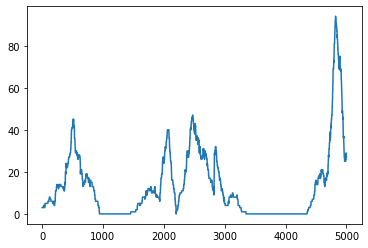

KeyboardInterrupt: 

In [128]:
while coverage.has_next():
    plt.plot(coverage.get_next_batch())
    plt.show()
    time.sleep(0.5)
    clear_output(wait=True)

In [129]:
clipped = SignalExtractor('chr21_Clipped.bedgraph.gz')

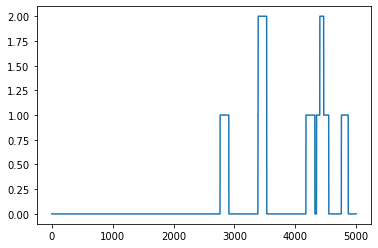

KeyboardInterrupt: 

In [130]:
while clipped.has_next():
    plt.plot(clipped.get_next_batch())
    plt.show()
    time.sleep(0.5)
    clear_output(wait=True)

## 6. Machine learning